In [406]:
%matplotlib inline
import sys
import queue
import copy
import pandas as pd
import networkx as nx
from itertools import product

In [407]:
# 기존 형식과 유사하게 Node class 정의
class Node:
    def __init__(self, id, linkedNode):
        self.id = id
        self.linkedNode = linkedNode

In [408]:
# node_list 정의(바둑판식 6x6)
node_list = []
for i in range(0, 21):
    node_list.append(Node(i, []))

node_list[0].linkedNode = [1, 16]
node_list[1].linkedNode = [0, 2]
node_list[2].linkedNode = [1, 3]
node_list[3].linkedNode = [2, 4]
node_list[4].linkedNode = [3, 5]
node_list[5].linkedNode = [4, 6, 7]
node_list[6].linkedNode = [5, 8]
node_list[7].linkedNode = [5, 8, 9]
node_list[8].linkedNode = [6, 7, 10]
node_list[9].linkedNode = [7, 10, 11]
node_list[10].linkedNode = [8, 9]
node_list[11].linkedNode = [9, 12]
node_list[12].linkedNode = [11, 13]
node_list[13].linkedNode = [12, 14]
node_list[14].linkedNode = [13, 15, 18]
node_list[15].linkedNode = [14, 16, 17]
node_list[16].linkedNode = [15, 0]
node_list[17].linkedNode = [15, 18, 19]
node_list[18].linkedNode = [17, 20]
node_list[19].linkedNode = [17, 20]
node_list[20].linkedNode = [18, 19]

In [421]:
# node_list 정의(바둑판식 6x6)
node_list = []
for i in range(0, 36):
    linkedNode = []
    if i+1 < 36 and (i+1)%6 != 0:
        linkedNode.append(i+1)
    if i-1 > -1 and (i-1)%6 != 5:
        linkedNode.append(i-1)
    if i+6 < 36:
        linkedNode.append(i+6)
    if i-6 > -1:
        linkedNode.append(i-6)
    node_list.append(Node(i, linkedNode))

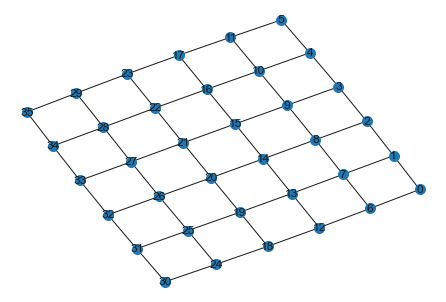

In [422]:
# 전체 그래프
G = nx.Graph()

# 0~35까지 노드 추가
for i in range(0, len(node_list)):
    G.add_node(i)

# 바둑판 식으로 edge 추가
for i in range(0, len(node_list)):
    for j in node_list[i].linkedNode:
        G.add_edge(i, j)

nx.draw(G, nx.kamada_kawai_layout(G), with_labels=True, node_size=100)

In [423]:
# cop의 다음 경로 정보(도착 지점 전 ID, 다음 node ID, 거리)
class Path:
    def __init__(self, robLinkedNodeID, nextNodeID, distance):
        self.robLinkedNodeID = robLinkedNodeID
        self.nextNodeID = nextNodeID
        self.distance = distance

In [424]:
def CalPath(startID, endID, copID):
    if startID == endID:
        return Path(endID, endID, 1)

    costs = {}
    parents = {}

    currentID = startID
    q = queue.Queue()
    q.put(currentID)
    costs[currentID] = 1

    while not q.empty():
        currentID = q.get()

        for nextID in node_list[currentID].linkedNode:
            if nextID != copID and ((nextID in costs and costs[nextID] >= costs[currentID] + 1) or nextID not in costs):
                costs[nextID] = costs[currentID] + 1
                parents[nextID] = currentID
                if nextID == endID:
                    q.queue.clear()
                else:
                    q.put(nextID)

    # 현재 linkedNode로 rob까지 도달할 수 없을 시
    if endID not in parents:
        return None
        
    return Path(parents[endID], startID, costs[endID])

In [425]:
def MoveNode(cur_cop_nodes, cur_rob_node):
    # robber linekd Node ID를 key로, r각 
    paths_to_rob = []

    for index, cop_node in enumerate(cur_cop_nodes):
        paths_to_rob.append([])

        if cop_node == cur_rob_node:
            paths_to_rob[index].append(Path(None, cur_rob_node, 0))
            continue

        for cop_linked_node in node_list[cop_node].linkedNode:
            cop_path = CalPath(cop_linked_node, cur_rob_node, cop_node)

            # 현재 linked node로 rob에게 도달할 수 없을 시
            if cop_path == None:
                continue
            
            paths_to_rob[index].append(cop_path)

    next_cop_nodes = copy.deepcopy(cur_cop_nodes)
    reachable_node_num = 0 # 도달 가능한 rob의 linked Node 수
    total_distance = sys.maxsize

    for path_to_rob in product(*paths_to_rob):
        temp_reachable_nodes = []
        temp_total_distance = 0
        
        for cop_path in path_to_rob:
            if cop_path.robLinkedNodeID not in temp_reachable_nodes:
                temp_reachable_nodes.append(cop_path.robLinkedNodeID)
            temp_total_distance += cop_path.distance
        
        if (len(temp_reachable_nodes) > reachable_node_num) or (len(temp_reachable_nodes) == reachable_node_num and temp_total_distance < total_distance):
            reachable_node_num = len(temp_reachable_nodes)
            total_distance = temp_total_distance
            next_cop_nodes = []
            for cop_path in path_to_rob:
                next_cop_nodes.append(cop_path.nextNodeID)

    return next_cop_nodes

In [426]:
# example 1
cur_cop_nodes = [12, 19, 20]
cur_rob_node = 0

In [432]:
# example 1
cur_cop_nodes = [35, 32, 12]
cur_rob_node = 10

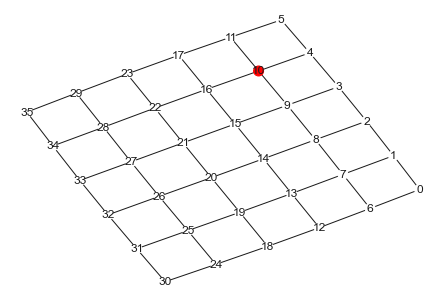

In [440]:
color_map = []
for cur_node in G:
    if cur_node == cur_cop_nodes[0]:
        color_map.append('red')
    elif cur_node == cur_cop_nodes[1]:
        color_map.append('green')
    elif cur_node == cur_cop_nodes[2]:
        color_map.append('blue')
    elif cur_node == cur_rob_node:
        color_map.append('black')
    else:
        color_map.append('white')

nx.draw(G, nx.kamada_kawai_layout(G), node_color=color_map, with_labels=True, node_size=100)

cur_cop_nodes = MoveNode(cur_cop_nodes, cur_rob_node)